In [1]:
%load_ext autoreload

In [139]:
%autoreload
import torch
import torch.nn as nn
import torchvision
import numpy as np
from gpt.model import ViT, Lambda, LightningWrapper
from gpt.alt_model import ViT as AltViT
from gpt.data import MNISTDataModule
from tqdm.auto import tqdm
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [3]:
mnist = MNISTDataModule(root_dir='/mnt/home/jshen/ceph/data/ml', num_workers=4, batch_size=8)
mnist.setup()

In [4]:
tl = mnist.test_dataloader()

In [143]:
x, y = next(iter(tl))

In [152]:
model = LightningWrapper.load_from_checkpoint('../train/lightning_logs/version_2954991/checkpoints/epoch=7-step=944.ckpt')

In [141]:
# model.load_state_dict(state_dict)
model.eval();
model.freeze()

In [79]:
def show(imgs, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

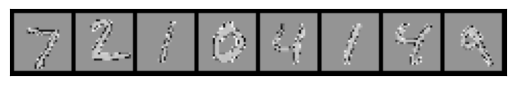

In [153]:
show(torchvision.utils.make_grid(x))

In [145]:
x.shape

torch.Size([8, 1, 28, 28])

In [154]:
with torch.no_grad():
    out = model(x).detach()

In [155]:
# torch.argmax(out, 1)

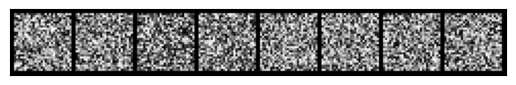

In [156]:
show(torchvision.utils.make_grid(out))